<a href="https://colab.research.google.com/github/kyj098707/Pix2PixTutorial/blob/main/GAN_Generative_Adversarial_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***GAN : Generative Adversarial Nets***

In [ ]:
import torch
import torch.nn as nn

from torchvision import datasets # MNIST 불러오기 용
import torchvision.transforms as transforms # 이미지 변형 용도
from torchvision.utils import save_image # 이미지 저장 후 보여주기 용도

- 생성자 판별자 모델 정의

In [ ]:
latent_dim = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블럭에서는 linear -> 배치 정규화 -> LeakyReLU 사용
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim,0.8))
            layers.append(nn.LeakyReLU(0.2,inplace=True))
            return layers

        # 위에서 정의한 블럭을 총 6개를 사용
        self.model = nn.Sequential(
            *block(latent_dim,128,normalize=False),
            *block(128,256),
            *block(256,512),
            *block(512,1024),
            nn.Linear(1024,1*28*28),
            nn.Tanh()
        )
    def forward(self,z):
        img = self.model(z)
        img = img.view(img.size(0),1,28,28)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1*28*28,512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        flattened = img.view(img.size(0),-1)
        output = self.model(flattened)

        return output

In [ ]:
datasets.MNIST

torchvision.datasets.mnist.MNIST

In [ ]:
transforms_train = transforms.Compose([
                                      transforms.Resize(28),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5],[0.5]),
])

train_dataset = datasets.MNIST(root ="./dataseet", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataseet/MNIST/raw/train-images-idx3-ubyte.gz to ./dataseet/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataseet/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataseet/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataseet/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataseet/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataseet/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataseet/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
G = Generator()
D = Discriminator()

In [ ]:
G.cuda()
D.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
import time

n_epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs,_) in enumerate(dataloader):
        real = torch.cuda.FloatTensor(imgs.size(0),1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0),1).fill_(0.0)

        real_imgs = imgs.cuda()

        optimizer_G.zero_grad()
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        generated_imgs = G(z)

        g_loss = adversarial_loss(D(generated_imgs),real)

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_loss = adversarial_loss(D(real_imgs),real)
        fake_loss = adversarial_loss(D(generated_imgs.detach()),fake)
        d_loss = (real_loss + fake_loss)/2

        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i

        if done % sample_interval == 0:
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.448547] [G loss: 1.258205] [Elapsed time: 16.78s]
[Epoch 1/200] [D loss: 0.523915] [G loss: 0.497543] [Elapsed time: 29.93s]
[Epoch 2/200] [D loss: 0.354217] [G loss: 2.092202] [Elapsed time: 43.00s]
[Epoch 3/200] [D loss: 0.431476] [G loss: 0.897236] [Elapsed time: 56.50s]
[Epoch 4/200] [D loss: 0.243856] [G loss: 3.349501] [Elapsed time: 69.62s]
[Epoch 5/200] [D loss: 0.235037] [G loss: 2.467269] [Elapsed time: 82.70s]
[Epoch 6/200] [D loss: 0.339220] [G loss: 1.041686] [Elapsed time: 95.97s]
[Epoch 7/200] [D loss: 0.329405] [G loss: 2.165486] [Elapsed time: 109.14s]
[Epoch 8/200] [D loss: 0.524161] [G loss: 1.439835] [Elapsed time: 122.31s]
[Epoch 9/200] [D loss: 0.376727] [G loss: 0.867682] [Elapsed time: 135.35s]
[Epoch 10/200] [D loss: 0.576554] [G loss: 4.025119] [Elapsed time: 148.41s]
[Epoch 11/200] [D loss: 0.391218] [G loss: 2.813426] [Elapsed time: 161.42s]
[Epoch 12/200] [D loss: 0.248073] [G loss: 1.432431] [Elapsed time: 174.59s]
[Epoch 13/200] [

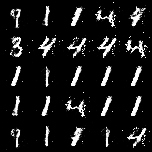

In [ ]:
from IPython.display import Image

Image('92000.png')